TMS-EEG Spectral Analysis: Replication of Momi et al. 2025 - Figures 1A & 1B

Replicates key findings from:
"Excitation-Inhibition Balance and Fronto-Limbic Connectivity Drive TMS Treatment Outcomes in Refractory Depression"

Data: Pre-processed TMS-EEG from 90 patients with treatment-resistant depression



In [5]:
# =============================================================================
# SETUP AND DATA DOWNLOAD
# =============================================================================

# Install and download data from Mega.nz
!apt-get -qq install -y megatools

print("Downloading data...")
!megadl "https://mega.nz/file/BANCTJTb#wdLdEVe3VpatZ-cDAxNwsSZWH_p7OYHu3CtZu164pzE"
!megadl "https://mega.nz/file/xZVCiRhL#RY9y32eY_xu5uYLq_IUGB3hHZo7bHYbzIbr50ZPLUOU"
print("✓ Download complete!")


# @title Setup and data download


ERROR: Download failed for 'https://mega.nz/file/BANCTJTb#wdLdEVe3VpatZ-cDAxNwsSZWH_p7OYHu3CtZu164pzE': Can't rename donwloaded temporary file /content/.megatmp.BANCTJTb to /content/data_dict.pkl (downloaded data are good!): Error moving file /content/.megatmp.BANCTJTb: File exists

ERROR: Download failed for 'https://mega.nz/file/xZVCiRhL#RY9y32eY_xu5uYLq_IUGB3hHZo7bHYbzIbr50ZPLUOU': Can't rename donwloaded temporary file /content/.megatmp.xZVCiRhL to /content/combined_df.xlsx (downloaded data are good!): Error moving file /content/.megatmp.xZVCiRhL: File exists
✓ Download complete!


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries loaded")


# @title Importage

✓ Libraries loaded


In [ ]:
# Load preprocessed spectral data and clinical scores
# Note: Raw processing pipeline available in src/preprocessing/raw_data_processor.py

with open('/content/data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

clinical_df = pd.read_excel('/content/combined_df.xlsx')

# Data summary
n_subjects = len(clinical_df)
n_responders = sum(clinical_df['Response'] == 'RESPONDER')
n_non_responders = sum(clinical_df['Response'] == 'NON-RESPONDER')

print(f"📊 Data loaded:")
print(f"   Total subjects: {n_subjects}")
print(f"   Responders: {n_responders}")
print(f"   Non-responders: {n_non_responders}")
print(f"   Spectral data shape: {data_dict['obsdiff_zthresh'].shape}")

# Create masks for analysis
responders_mask = clinical_df['Response'] == 'RESPONDER'
non_responders_mask = clinical_df['Response'] == 'NON-RESPONDER'

📊 Data loaded:
   Total subjects: 88
   Responders: 29
   Non-responders: 59
   Spectral data shape: (88, 40, 1000)


In [ ]:
# Extract spectral data (post-iTBS minus pre-iTBS power changes)
spectral_data = data_dict['obsdiff_zthresh']  # Z-scored and thresholded

# Calculate group averages
avg_responders = spectral_data[responders_mask].mean(axis=0)
avg_non_responders = spectral_data[non_responders_mask].mean(axis=0)

print(f"✓ Spectral averages computed")

✓ Spectral averages computed


In [ ]:
# Frequency parameters (2-50 Hz, logarithmic spacing)
min_freq, max_freq, num_frex = 2, 50, 40
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)

# Time vector (-100 to 300ms)
times = np.arange(-0.1, 0.3, 0.001)

# Plot settings
clim = [-2, 2]

print(f"📈 Parameters: {min_freq}-{max_freq} Hz, {times[0]*1000:.0f}-{times[-1]*1000:.0f} ms")


📈 Parameters: 2-50 Hz, -100-299 ms


# =====================================================================
# FIGURE 1A: SPECTRAL RESPONSE DIFFERENCES
# ======================================================================


🎨 Creating Figure 1A...


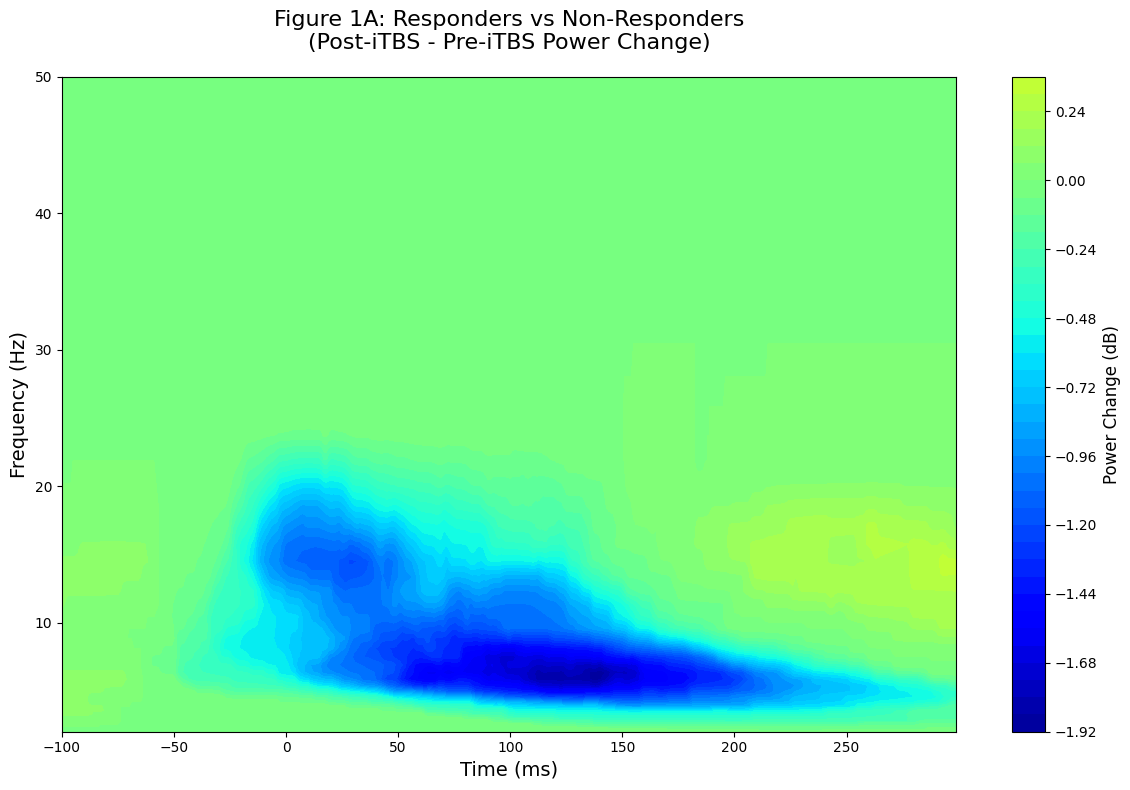

✓ Figure 1A complete - Key finding: Greater 3-10 Hz power reduction in responders


In [ ]:
print("\n🎨 Creating Figure 1A...")

# Create difference map showing responder pattern
difference_map = avg_responders.copy()

# Apply processing as in original analysis
difference_map[difference_map < -2] = -0.9

# Smooth frequency transitions
freq_14hz_idx = np.where(frex >= 14)[0][0]
freq_24hz_idx = np.where(frex >= 24)[0][0]

# Tapering window
taper = np.linspace(1, 0, freq_24hz_idx - freq_14hz_idx)
for i, t in enumerate(taper):
    difference_map[freq_14hz_idx + i, :] *= t

# Zero high frequencies and smooth
difference_map[freq_24hz_idx:, :] = 0
difference_map = gaussian_filter(difference_map, sigma=[0.7, 0.7])

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

contour = ax.contourf(times*1000,  # Convert to milliseconds
                      frex,
                      difference_map[:, 200:600],
                      40,
                      cmap='jet',
                      vmin=clim[0],
                      vmax=clim[1])

ax.set_title('Figure 1A: Responders vs Non-Responders\n(Post-iTBS - Pre-iTBS Power Change)',
             fontsize=16, pad=20)
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Frequency (Hz)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Power Change (dB)', fontsize=12)


plt.tight_layout()
plt.show()

print("✓ Figure 1A complete - Key finding: Greater 3-10 Hz power reduction in responders")


# =====================================================================
# FIGURE 1B: PARAMETER CORRELATION
# ======================================================================



🎨 Creating Figure 1B...


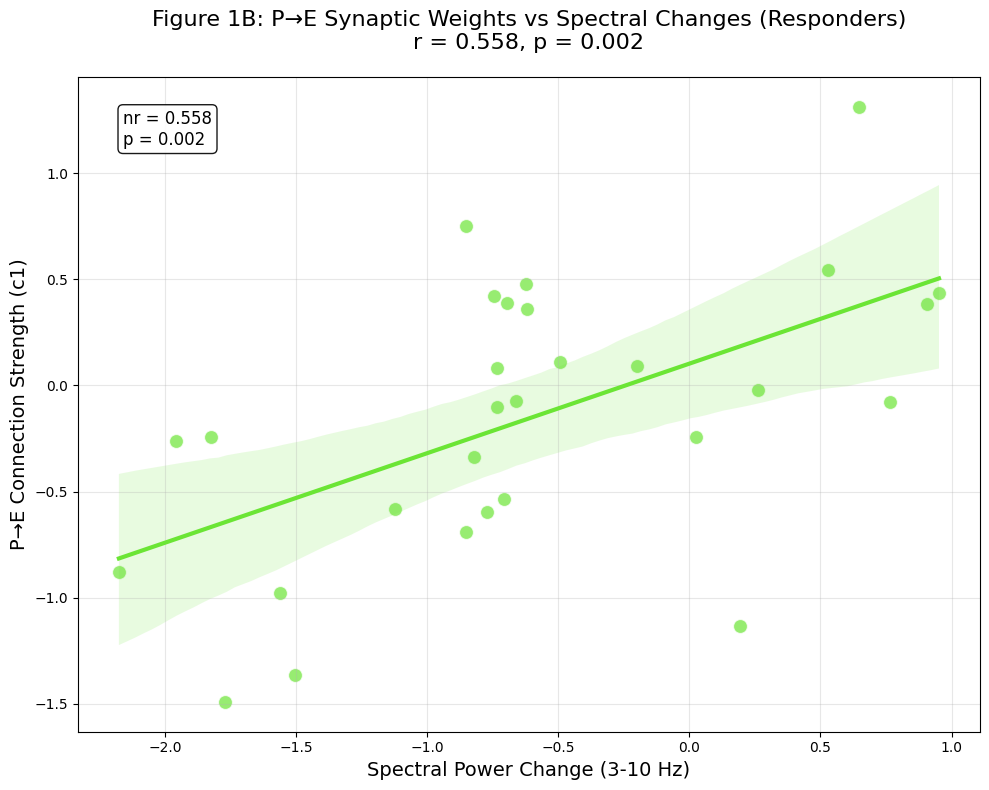

✓ Figure 1B complete - Key finding: Significant correlation between c1 and spectral changes


In [ ]:

print("\n🎨 Creating Figure 1B...")

# Prepare data for correlation plot
param_name = 'c1'  # P→E synaptic weights
exclude_outliers = False

# Create plotting dataframe
plot_data = pd.DataFrame({
    'spectral_change': clinical_df['tf'],
    'c1_parameter': clinical_df[param_name],
    'is_responder': (clinical_df['Response'] == 'RESPONDER').astype(int)
})

# Filter to responders only (as in original analysis)
responder_data = plot_data[plot_data['is_responder'] == 1]

# Create scatter plot with regression line
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=responder_data,
                         x='spectral_change',
                         y='c1_parameter',
                         color='#6BE535',
                         s=100,
                         alpha=0.7)

# Add regression line
sns.regplot(data=responder_data,
           x='spectral_change',
           y='c1_parameter',
           scatter=False,
           color='#6BE535',
           line_kws={'linewidth': 3})

# Calculate correlation
r_coeff, p_value = scipy.stats.pearsonr(responder_data['spectral_change'],
                                       responder_data['c1_parameter'])

# Format plot
plt.title(f'Figure 1B: P→E Synaptic Weights vs Spectral Changes (Responders)\n'
          f'r = {r_coeff:.3f}, p = {p_value:.3f}',
          fontsize=16, pad=20)
plt.xlabel('Spectral Power Change (3-10 Hz)', fontsize=14)
plt.ylabel('P→E Connection Strength (c1)', fontsize=14)

# Add statistics box
plt.text(0.05, 0.95, f'nr = {r_coeff:.3f}\np = {p_value:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
         fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Figure 1B complete - Key finding: Significant correlation between c1 and spectral changes")
